# Building your own DCGAN

In [30]:
import torch
from torch import nn
from torchvision.datasets import FashionMNIST

## Download, Analyze, & Visualize the dataset

### Download

In [31]:
dataset_dir = "../datasets/"

In [32]:
train_dataset = FashionMNIST(root=dataset_dir,
                             train=True,
                             download=False)

test_dataset = FashionMNIST(root=dataset_dir,
                            train=False,
                            download=False)

### Analyze

In [33]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../datasets/
    Split: Train

In [34]:
test_dataset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ../datasets/
    Split: Test

In [35]:
# classes
class_names = train_dataset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [36]:
# sample
img, label = train_dataset[0]
img, label

(<PIL.Image.Image image mode=L size=28x28>, 9)

### Visualize

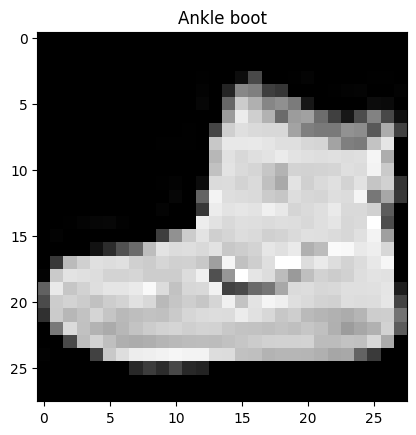

In [37]:
# single sample
import matplotlib.pyplot as plt

plt.imshow(img, cmap='gray')
plt.title(f"{class_names[label]}");

In [38]:
# single sample: fancy visualization
import matplotlib as mpl

def img_pixel_superimpose(img, ax):
    """Expecting gray-scale image"""
    h, w = img.shape
    
    color_map = mpl.colormaps.get_cmap('gray_r')
    ax.imshow(img, cmap='gray')
    for y in range(h):
        for x in range(w):
            color = color_map(img[y][x])
            plt.annotate(text=f"{img[y][x]}", xy=(x,y),
                         horizontalalignment='center',
                         verticalalignment='center',
                         color=color)

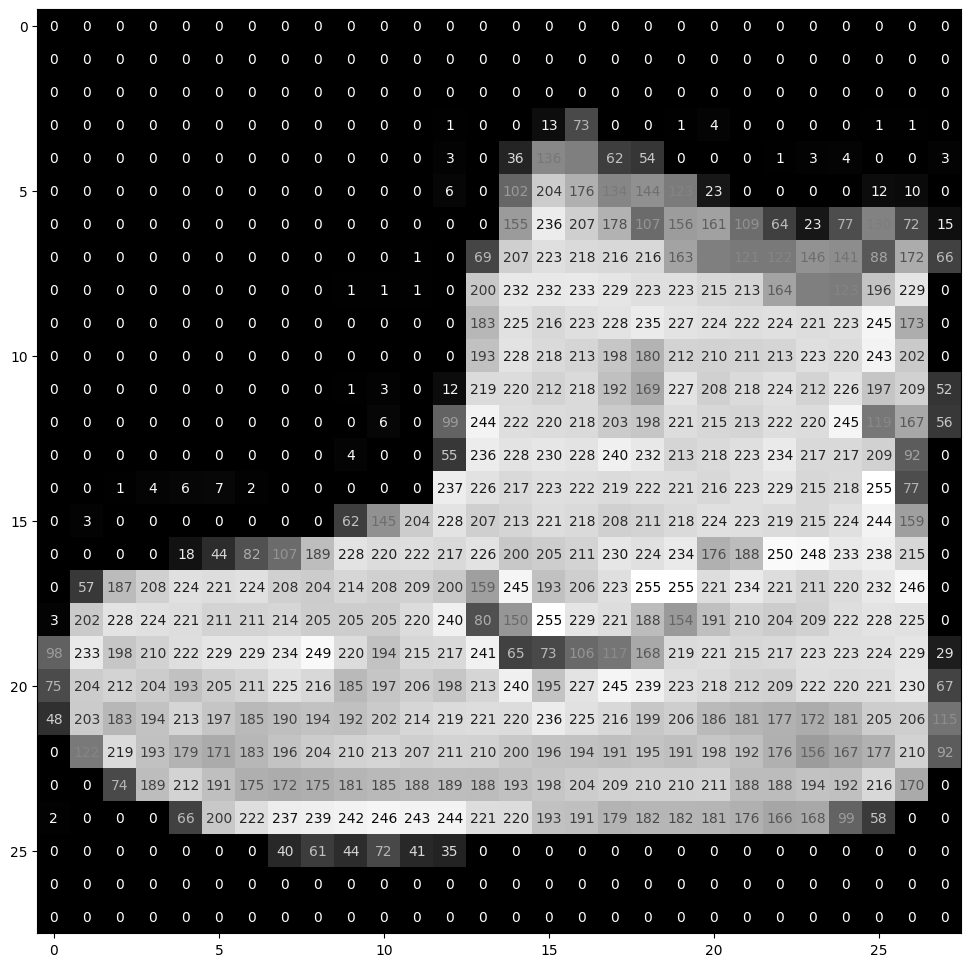

In [39]:
import numpy as np

img_arr = np.array(img)
# print(img_arr.shape)

fig = plt.figure(figsize=(12, 12)) 
ax = fig.add_subplot(1, 1, 1)

img_pixel_superimpose(img_arr, ax)

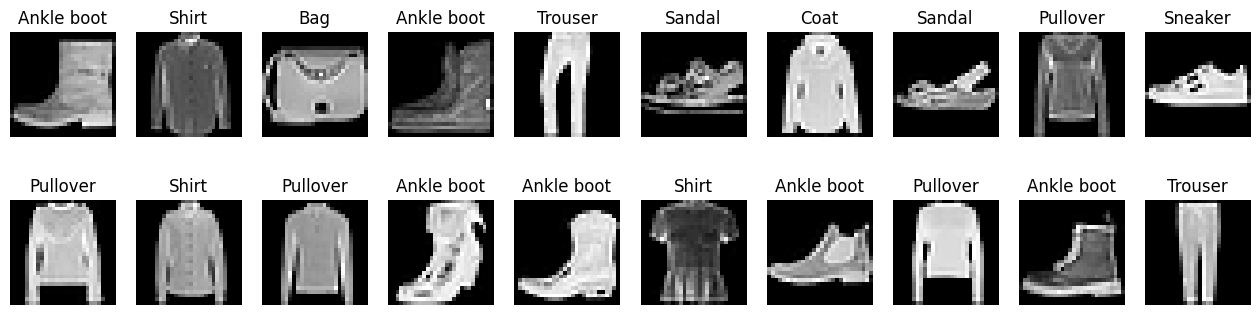

In [40]:
# batch of random samples

torch.manual_seed(42)

fig = plt.figure(figsize=(16, 4))
rows, cols = 2, 10
for i in range(1, ((rows * cols) + 1)):
    rand_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[rand_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap='gray')
    plt.title(f"{class_names[label]}")
    plt.axis(False)

### Transform

In [41]:
from torchvision import transforms

In [42]:
transforms_fmnist = transforms.Compose([transforms.ToTensor()])
transforms_fmnist

Compose(
    ToTensor()
)

In [43]:
train_dataset = FashionMNIST(root=dataset_dir,
                             train=True,
                             download=False,
                             transform=transforms_fmnist)

test_dataset = FashionMNIST(root=dataset_dir,
                            train=False,
                            download=True,
                            transform=transforms_fmnist)

### Dataloaders

In [44]:
from torch.utils.data import DataLoader

In [45]:
BATCH_SIZE = 32

In [46]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

len(train_dataloader), len(test_dataloader)

(1875, 313)

In [47]:
imgs, labels = next(iter(train_dataloader))
imgs.shape, labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## Model

### Generator

In [48]:
import torch
import torch.nn as nn

In [49]:
class Generator(nn.Module):
    def __init__(self, latent_dim, channels):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=128*7*7),  #7x7
            nn.ReLU(inplace=True),
            
            nn.Unflatten(dim=1, unflattened_size=(128, 7, 7)),
            
            nn.Upsample(scale_factor=2),  #14x14
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128, momentum=0.8),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2), #28x28
            
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64, momentum=0.8),
            nn.ReLU(inplace=True),            
            
            nn.Conv2d(in_channels=64, out_channels=channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, z):
        return self.model(z)
            

### Discriminator

In [50]:
class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=3, stride=2, padding=1), #14x14
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(p=0.25),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1), #7x7
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(p=0.25),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1), #4x4
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(p=0.25),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1), #4x4
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(p=0.25)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=4*4*256, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.classifier(self.features(x))
    

## Loss, Optimizer, Metrics

In [51]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Hyperparameters
latent_dim = 100
channels = 1
epochs = 15
lr = 0.0002
beta1 = 0.5

Device: cuda


In [52]:
# Loss function
adversarial_loss = nn.BCELoss()

In [53]:
# Initialize generator and discriminator
generator = Generator(latent_dim, channels).to(device)
discriminator = Discriminator(channels).to(device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [54]:
from torchinfo import summary

In [56]:
summary(model=generator, input_size=(1, 100))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 1, 28, 28]            --
├─Sequential: 1-1                        [1, 1, 28, 28]            --
│    └─Linear: 2-1                       [1, 6272]                 633,472
│    └─ReLU: 2-2                         [1, 6272]                 --
│    └─Unflatten: 2-3                    [1, 128, 7, 7]            --
│    └─Upsample: 2-4                     [1, 128, 14, 14]          --
│    └─Conv2d: 2-5                       [1, 128, 14, 14]          147,584
│    └─BatchNorm2d: 2-6                  [1, 128, 14, 14]          256
│    └─ReLU: 2-7                         [1, 128, 14, 14]          --
│    └─Upsample: 2-8                     [1, 128, 28, 28]          --
│    └─Conv2d: 2-9                       [1, 64, 28, 28]           73,792
│    └─BatchNorm2d: 2-10                 [1, 64, 28, 28]           128
│    └─ReLU: 2-11                        [1, 64, 28, 28]           --

In [57]:
summary(model=discriminator, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 256, 4, 4]            --
│    └─Conv2d: 2-1                       [1, 32, 14, 14]           320
│    └─LeakyReLU: 2-2                    [1, 32, 14, 14]           --
│    └─Dropout: 2-3                      [1, 32, 14, 14]           --
│    └─Conv2d: 2-4                       [1, 64, 7, 7]             18,496
│    └─BatchNorm2d: 2-5                  [1, 64, 7, 7]             128
│    └─LeakyReLU: 2-6                    [1, 64, 7, 7]             --
│    └─Dropout: 2-7                      [1, 64, 7, 7]             --
│    └─Conv2d: 2-8                       [1, 128, 4, 4]            73,856
│    └─BatchNorm2d: 2-9                  [1, 128, 4, 4]            256
│    └─LeakyReLU: 2-10                   [1, 128, 4, 4]            --
│    └─Dropout: 2-11                     [1, 128, 4, 4]            --
│   

## Training

In [58]:
# Training loop
for epoch in range(epochs):
    for (imgs, _) in train_dataloader:
        
        # Adversarial ground truths
        valid = torch.ones((imgs.size(0), 1)).to(device)
        fake = torch.zeros((imgs.size(0), 1)).to(device)
        
        # Configure input
        real_imgs = imgs.to(device)
        z = torch.randn((BATCH_SIZE, latent_dim)).to(device)
        
        # Train Generator
        optimizer_G.zero_grad()
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    # Print loss
    print(f"EPOCH: {epoch} | D_Loss: {d_loss.item():.5f} | G_Loss: {g_loss.item():.5f}")

EPOCH: 0 | D_Loss: 0.51322 | G_Loss: 1.45654
EPOCH: 1 | D_Loss: 0.30519 | G_Loss: 2.73769
EPOCH: 2 | D_Loss: 0.41015 | G_Loss: 1.94145
EPOCH: 3 | D_Loss: 0.23714 | G_Loss: 2.02939
EPOCH: 4 | D_Loss: 0.14265 | G_Loss: 1.14447
EPOCH: 5 | D_Loss: 0.40410 | G_Loss: 2.00421
EPOCH: 6 | D_Loss: 0.36774 | G_Loss: 1.55634
EPOCH: 7 | D_Loss: 0.27968 | G_Loss: 2.62510
EPOCH: 8 | D_Loss: 0.25335 | G_Loss: 3.46009
EPOCH: 9 | D_Loss: 0.34031 | G_Loss: 1.90131
EPOCH: 10 | D_Loss: 0.39124 | G_Loss: 3.06573
EPOCH: 11 | D_Loss: 0.29339 | G_Loss: 3.52942
EPOCH: 12 | D_Loss: 0.23119 | G_Loss: 2.21051
EPOCH: 13 | D_Loss: 0.71864 | G_Loss: 0.33364
EPOCH: 14 | D_Loss: 0.12433 | G_Loss: 4.37567


## Save the model

In [59]:
import os

model_save_path = "./models/"
model_name = f"dcgan_fmnist_{epochs}.pt"

In [60]:
torch.save({"generator_state_dict": generator.state_dict(),
            "discriminator_state_dict": discriminator.state_dict()},
           os.path.join(model_save_path, model_name))

## Load the model

In [61]:
model_trained = torch.load(os.path.join(model_save_path, model_name))

In [62]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [64]:
latent_dim = 100
generator_loaded = Generator(latent_dim, channels)
generator_loaded.load_state_dict(model_trained["generator_state_dict"])

<All keys matched successfully>

In [65]:
generator_loaded = generator_loaded.to(device);

## Inferences

In [100]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

### Single

In [101]:
noise_test = torch.randn(latent_dim)
noise_test.unsqueeze_(dim=0)
print(noise_test.shape)
noise_test = noise_test.to(device)

torch.Size([1, 100])


In [102]:
generator_loaded.eval()

with torch.inference_mode():
    gan_img_test = generator_loaded(noise_test)
    
gan_img_test.shape

torch.Size([1, 1, 28, 28])

In [103]:
gan_img_test = gan_img_test.squeeze().to('cpu').detach().numpy()

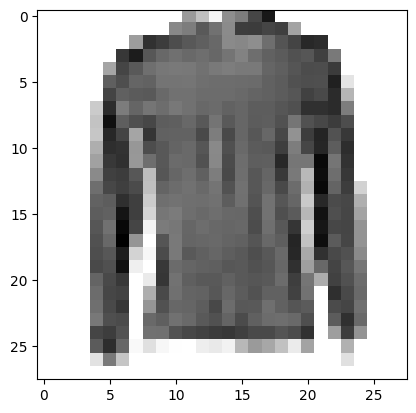

In [104]:
import matplotlib.pyplot as plt

plt.imshow(gan_img_test, cmap='gray_r')

### Multiple

In [105]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [106]:
examples = 100
latent_dim = 100

noise_inputs = torch.randn(examples, latent_dim)
noise_inputs.shape

torch.Size([100, 100])

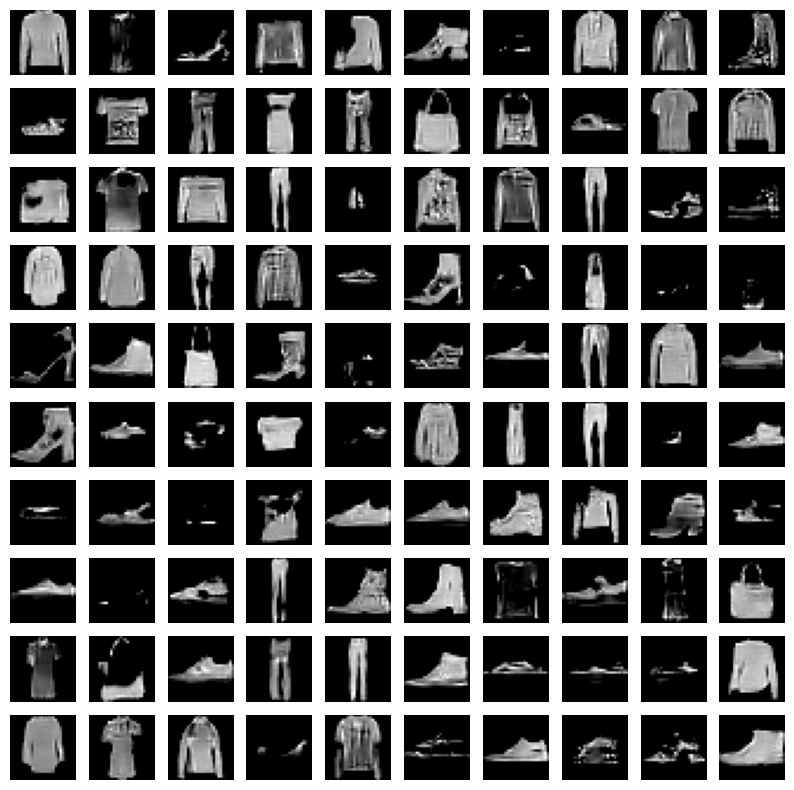

In [109]:
generator_loaded.eval()

rows = 10
cols = 10

fig = plt.figure(figsize=(10, 10))
for i in range(1, (rows * cols) + 1):
    noise_input = noise_inputs[i-1]
    noise_input = noise_input.unsqueeze_(dim=0).to(device)
    with torch.inference_mode():
        gan_output = generator_loaded(noise_input)
    gan_output = gan_output.squeeze().to('cpu').detach().numpy()
    fig.add_subplot(rows, cols, i)
    plt.imshow(gan_output, cmap='gray')
    plt.axis(False)